In [1]:
import numpy as np
import pandas as pd
from enum import IntEnum
import matplotlib.pyplot as plt

from mesa import Model, Agent
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.batchrunner import batch_run
from mesa.datacollection import DataCollector

In [2]:
class State(IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

# Age distribution in Austria

https://wibis-steiermark.at/bevoelkerung/struktur/einwohner-nach-altersklassen/

In [3]:
def get_age():
    age_ranges = [(0, 15), (15, 20), (20, 25), (25, 30), (30, 45), (45, 60), (60, 65), (65, 75), (75, 101)]
    total_population = 9104772
    age_population = [1315044, 446517, 502389, 592713, 1866278, 1970352, 630776, 913691, 867012]
    age_percentages = [age / total_population for age in age_population]

    age_range = np.random.choice(len(age_ranges), p=age_percentages)
    min_age, max_age = age_ranges[age_range]
    age = np.random.randint(min_age, max_age)

    return age

# Death rate by age until end 2021 Austria

https://www.statistik.at/fileadmin/announcement/2022/05/20220125SterberatenImpfstatus.pdf

In [4]:
def get_death_prob(age):
    age_groups = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 101)]
    deaths_per_age_group = [15, 35, 212, 1430, 9560]
    sample_size = 100000
    deaths_percentages = [death / sample_size for death in deaths_per_age_group]

    index = next((i for i, (start, end) in enumerate(age_groups) if start <= age < end), None)
    return deaths_percentages[index]


In [5]:
class SIRAgentBasic(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = get_age()
        model.agent_ages.append(self.age)
        self.death_prob = get_death_prob(self.age)
        self.state = State.SUSCEPTIBLE
        self.infection_time = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        if self.state == State.INFECTED:
            if np.random.random() < self.death_prob: # chance of "dying"
                self.model.schedule.remove(self)
                self.model.dead_agents.append(self)
            else:
                t = self.model.schedule.time - self.infection_time
                if t >= self.recovery_time:
                    self.state = State.REMOVED

    def contact(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for other in cellmates:
            if self.random.random() <= self.model.ptrans: #  transmission probability
                if (self.state is State.INFECTED and other.state is State.SUSCEPTIBLE):
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = self.model.get_recovery_time()

    def step(self):
        self.status()
        self.move()
        self.contact()

In [6]:
def get_number_of_deaths(model):
    return len(model.dead_agents)

In [7]:
class SIRModelBasic(Model):
    def __init__(self, N, ptrans, recovery_days, recovery_sd, initial_infections, width, height):

        super().__init__()

        self.num_agents = N
        self.ptrans = ptrans
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd

        self.grid = MultiGrid(width, height, True) # each cell can contain more than one agent
        self.schedule = RandomActivation(self)
        self.running = True

        self.agent_ages = []
        self.dead_agents = []

        self.datacollector = DataCollector(
            model_reporters={"Nr_Deaths": get_number_of_deaths},
            agent_reporters={"State": "state"})

        # Create agents
        for id in range(self.num_agents):
            agent = SIRAgentBasic(id, self)
            self.schedule.add(agent)

            # Place random on grid
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

            # Make some agents infected at start
            infected = np.random.choice([False, True], p=[1 - initial_infections, initial_infections])
            if infected:
                agent.state = State.INFECTED
                agent.recovery_time = self.get_recovery_time()

    # Calculates recovery time for an agent based on a normal distribution
    # with mean (recovery_days) and standard deviation (recovery_sd).
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days, self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Model Parameters:
* N = Number of agents
* ptrans = transmission probability
* recovery_days & sd = params for normal distribution of recovery time
* initial_infections = probability a agents is infected at step 0

# Analysis Model Basic

In [8]:
def pseudo_batch_runner_basic(nr_of_runs, plt_info, params):
    model_ages = []
    agent_basic_out = []
    model_basic_out = []

    for i in range(nr_of_runs):
        model_basic = SIRModelBasic(params['N'], params['ptrans'], params['recovery_days'], params['recovery_sd'],
                                    params['initial_infections'], params['width'], params['height'])

        while model_basic.schedule.steps < 100:
            model_basic.step()

        print(f'Iteration {i}: Basic Infection Model ran for {model_basic.schedule.steps} steps')
        model_ages.extend(model_basic.agent_ages)
        agent_basic_out.append(model_basic.datacollector.get_agent_vars_dataframe())
        model_basic_out.append(model_basic.datacollector.get_model_vars_dataframe())

    agent_runs_df = pd.concat(agent_basic_out, ignore_index=False)
    mean_agent_runs_df = agent_runs_df.groupby("Step").value_counts() / nr_of_runs
    states_over_steps = mean_agent_runs_df.unstack(fill_value=0)

    plt.hist(model_ages, bins=range(101), align='left')
    plt.xticks(range(0, 101, 10))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram Agent Ages')
    plt.show()

    plt.plot(states_over_steps[0], label='SUSCEPTIBLE')
    plt.plot(states_over_steps[1], label='INFECTED')
    plt.plot(states_over_steps[2], label='REMOVED')
    plt.title('Infection over Time ' + plt_info)
    plt.xlabel('Step')
    plt.ylabel('Number of Agents')
    plt.legend()
    plt.show()

    model_runs_df = pd.concat(model_basic_out, ignore_index=False)
    mean_model_runs_df = model_runs_df.groupby(model_runs_df.index).mean()

    plt.plot(mean_model_runs_df['Nr_Deaths'], label='Nr. of Deaths')
    plt.plot(states_over_steps[1], label='Infections')
    plt.title('Number of Deaths vs Infected ' + plt_info)
    plt.xlabel('Step')
    plt.ylabel('Number of Agents')
    plt.legend()
    plt.show()

## Test different parameters

### Transmission probabilities of 10%, 50% and 90%

Iteration 0: Basic Infection Model ran for 100 steps
Iteration 1: Basic Infection Model ran for 100 steps
Iteration 2: Basic Infection Model ran for 100 steps
Iteration 3: Basic Infection Model ran for 100 steps
Iteration 4: Basic Infection Model ran for 100 steps
Iteration 5: Basic Infection Model ran for 100 steps
Iteration 6: Basic Infection Model ran for 100 steps
Iteration 7: Basic Infection Model ran for 100 steps
Iteration 8: Basic Infection Model ran for 100 steps
Iteration 9: Basic Infection Model ran for 100 steps


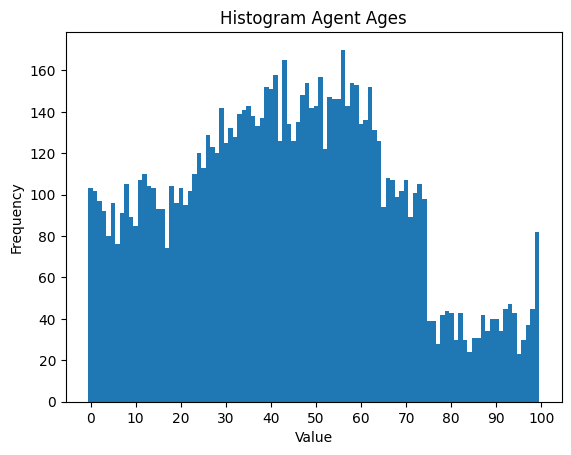

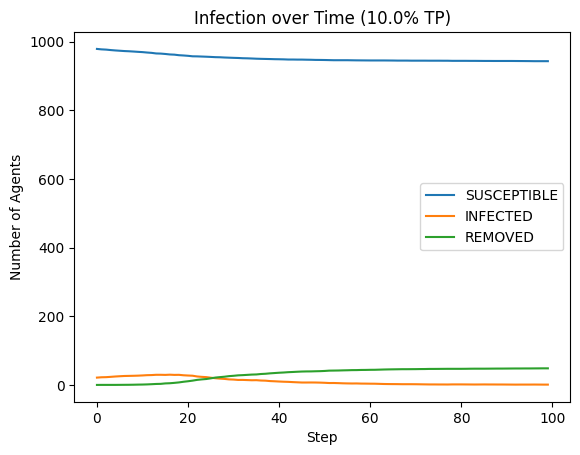

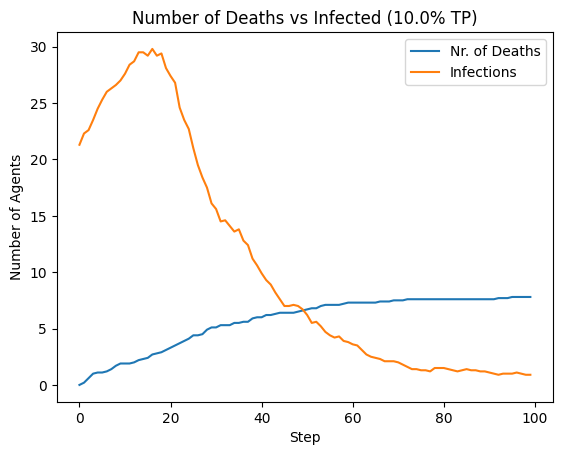

Iteration 0: Basic Infection Model ran for 100 steps
Iteration 1: Basic Infection Model ran for 100 steps
Iteration 2: Basic Infection Model ran for 100 steps
Iteration 3: Basic Infection Model ran for 100 steps
Iteration 4: Basic Infection Model ran for 100 steps
Iteration 5: Basic Infection Model ran for 100 steps
Iteration 6: Basic Infection Model ran for 100 steps
Iteration 7: Basic Infection Model ran for 100 steps
Iteration 8: Basic Infection Model ran for 100 steps
Iteration 9: Basic Infection Model ran for 100 steps


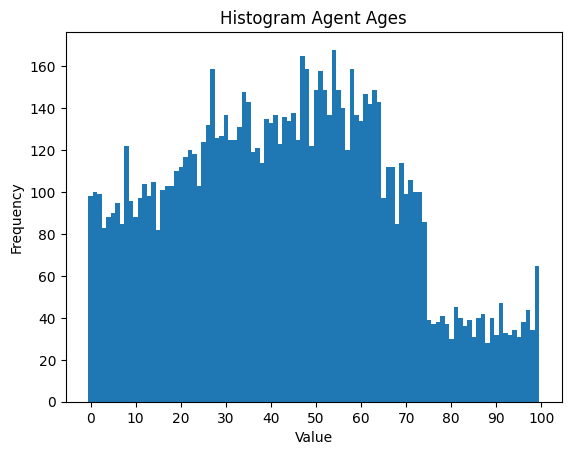

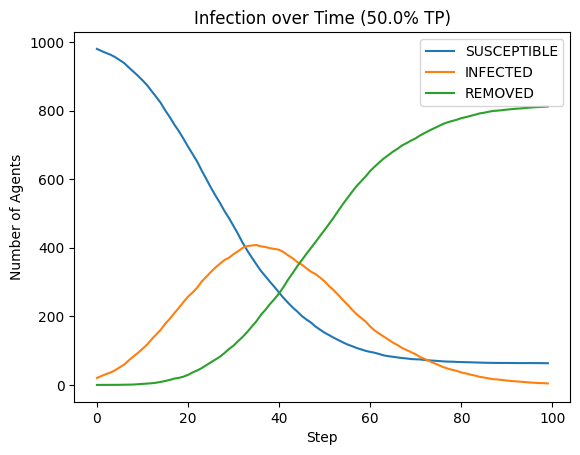

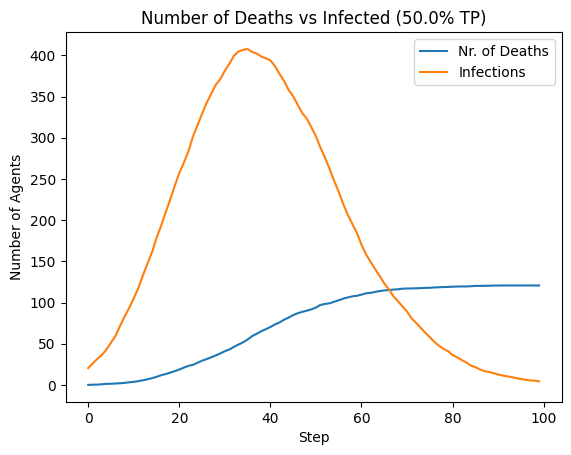

Iteration 0: Basic Infection Model ran for 100 steps
Iteration 1: Basic Infection Model ran for 100 steps
Iteration 2: Basic Infection Model ran for 100 steps
Iteration 3: Basic Infection Model ran for 100 steps
Iteration 4: Basic Infection Model ran for 100 steps
Iteration 5: Basic Infection Model ran for 100 steps
Iteration 6: Basic Infection Model ran for 100 steps
Iteration 7: Basic Infection Model ran for 100 steps
Iteration 8: Basic Infection Model ran for 100 steps
Iteration 9: Basic Infection Model ran for 100 steps


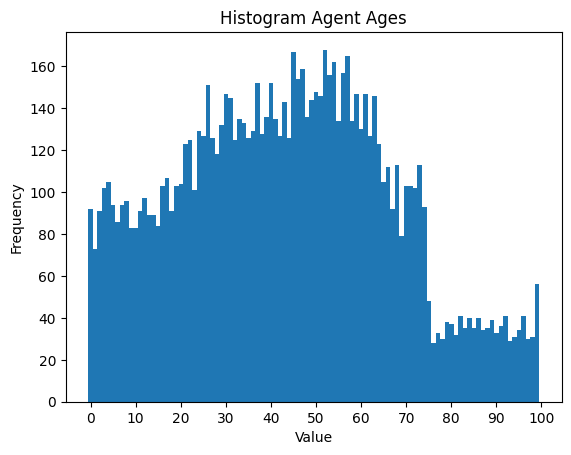

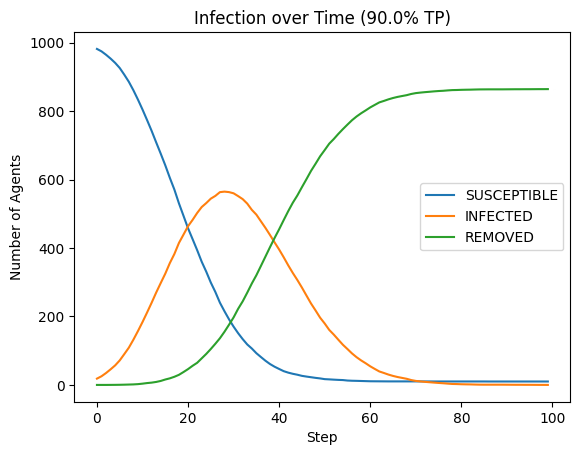

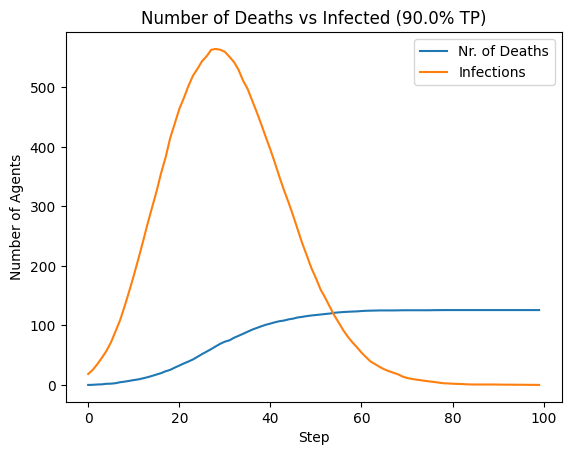

In [9]:
params = {'N': 1000,
          'ptrans': 0.1,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 50,
          'height': 50}

pseudo_batch_runner_basic(10, f"({params['ptrans'] * 100}% TP)", params)

params['ptrans'] = 0.5
pseudo_batch_runner_basic(10, f"({params['ptrans'] * 100}% TP)", params)

params['ptrans'] = 0.9
pseudo_batch_runner_basic(10, f"({params['ptrans'] * 100}% TP)", params)

### Different Grid Sizes with and 50% transmission probabilities

Iteration 0: Basic Infection Model ran for 100 steps
Iteration 1: Basic Infection Model ran for 100 steps
Iteration 2: Basic Infection Model ran for 100 steps
Iteration 3: Basic Infection Model ran for 100 steps
Iteration 4: Basic Infection Model ran for 100 steps
Iteration 5: Basic Infection Model ran for 100 steps
Iteration 6: Basic Infection Model ran for 100 steps
Iteration 7: Basic Infection Model ran for 100 steps
Iteration 8: Basic Infection Model ran for 100 steps
Iteration 9: Basic Infection Model ran for 100 steps


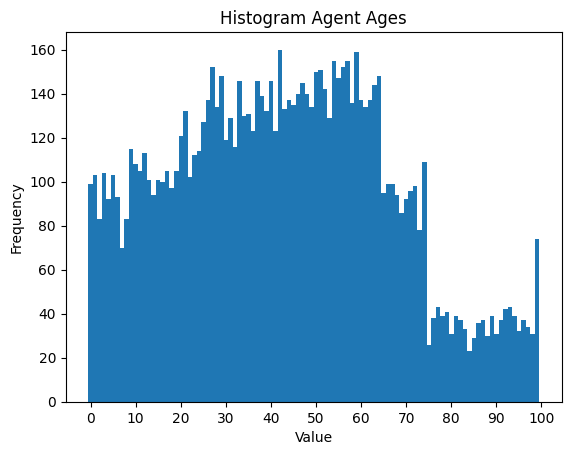

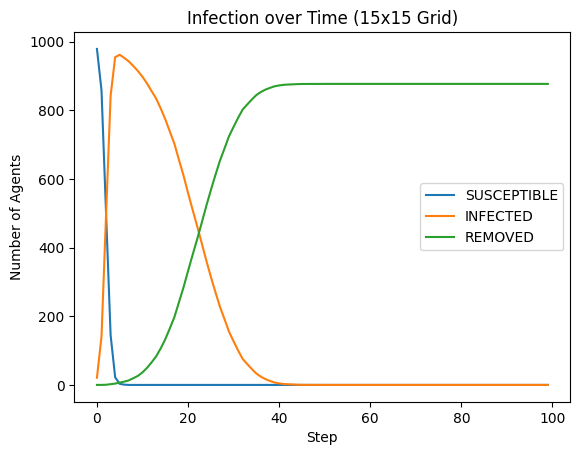

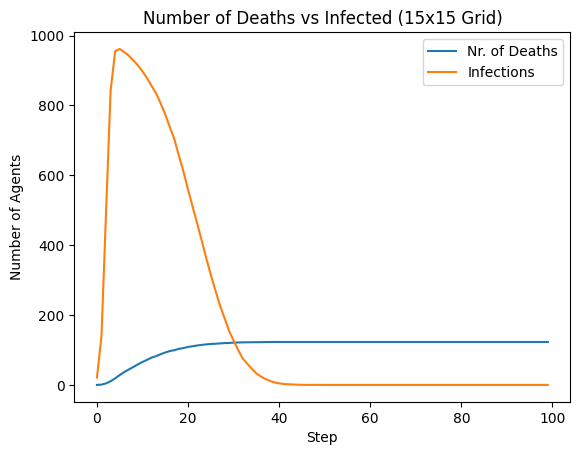

Iteration 0: Basic Infection Model ran for 100 steps
Iteration 1: Basic Infection Model ran for 100 steps
Iteration 2: Basic Infection Model ran for 100 steps
Iteration 3: Basic Infection Model ran for 100 steps
Iteration 4: Basic Infection Model ran for 100 steps
Iteration 5: Basic Infection Model ran for 100 steps
Iteration 6: Basic Infection Model ran for 100 steps
Iteration 7: Basic Infection Model ran for 100 steps
Iteration 8: Basic Infection Model ran for 100 steps
Iteration 9: Basic Infection Model ran for 100 steps


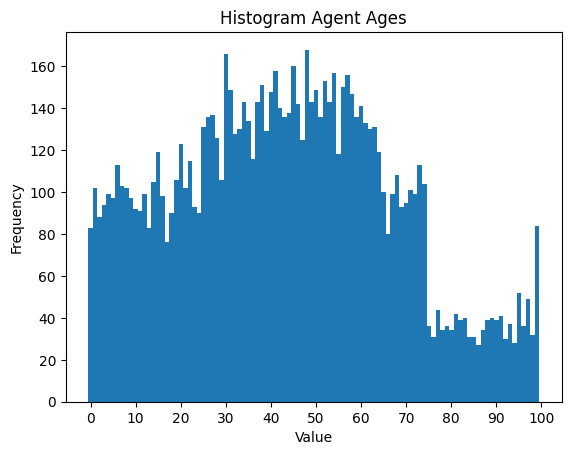

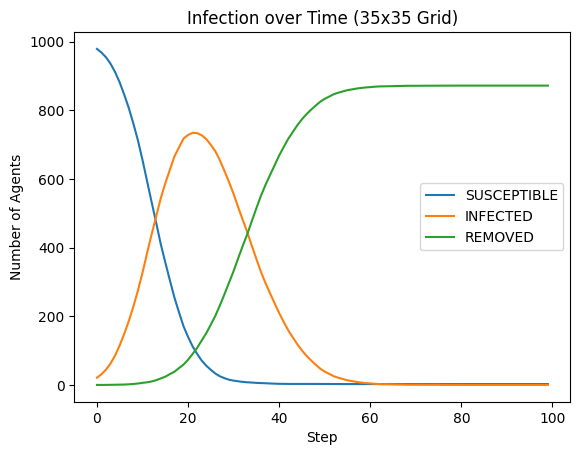

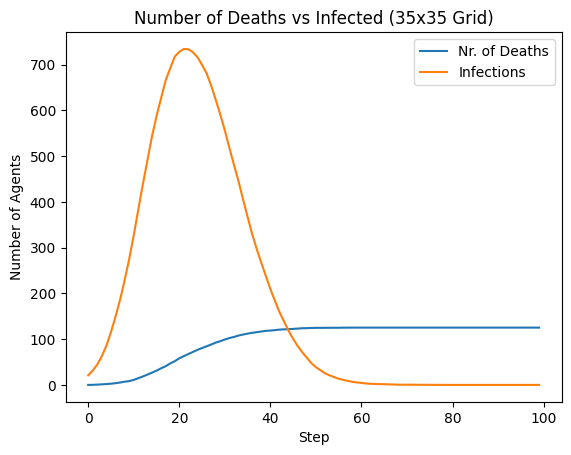

Iteration 0: Basic Infection Model ran for 100 steps
Iteration 1: Basic Infection Model ran for 100 steps
Iteration 2: Basic Infection Model ran for 100 steps
Iteration 3: Basic Infection Model ran for 100 steps
Iteration 4: Basic Infection Model ran for 100 steps
Iteration 5: Basic Infection Model ran for 100 steps
Iteration 6: Basic Infection Model ran for 100 steps
Iteration 7: Basic Infection Model ran for 100 steps
Iteration 8: Basic Infection Model ran for 100 steps
Iteration 9: Basic Infection Model ran for 100 steps


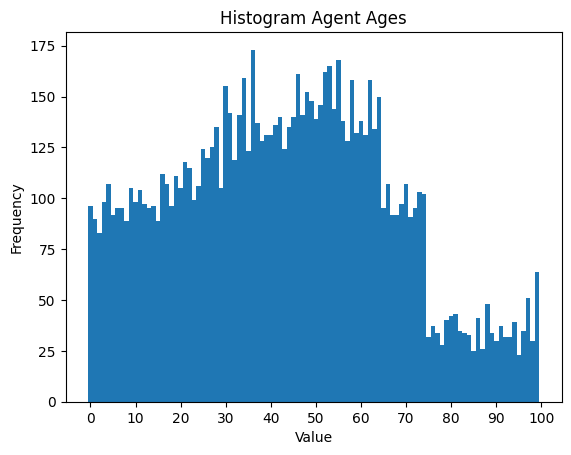

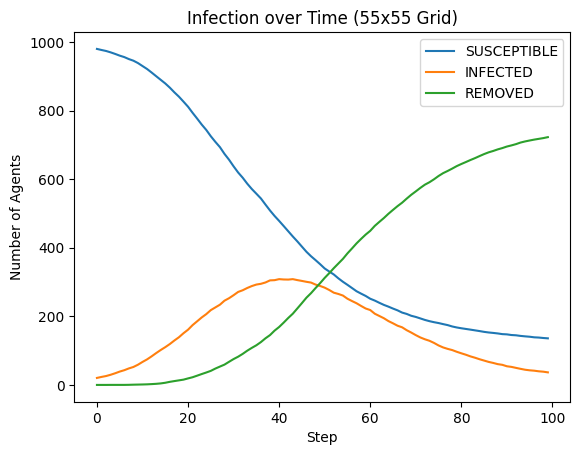

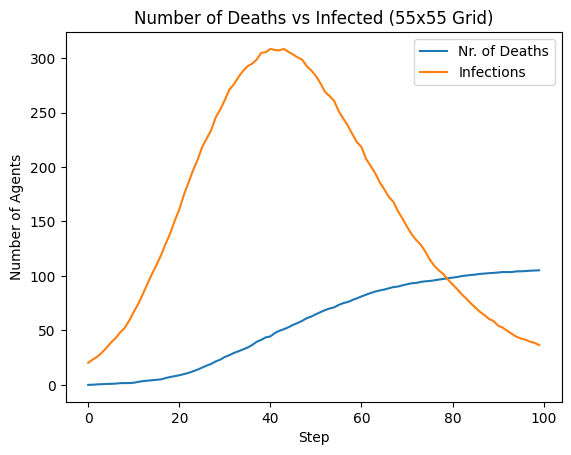

In [10]:
params = {'N': 1000,
          'ptrans': 0.5,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 15,
          'height': 15}

pseudo_batch_runner_basic(10, f"({params['width']}x{params['height']} Grid)", params)

params['width'] = 35
params['height'] = 35
pseudo_batch_runner_basic(10, f"({params['width']}x{params['height']} Grid)", params)

params['width'] = 55
params['height'] = 55
pseudo_batch_runner_basic(10, f"({params['width']}x{params['height']} Grid)", params)

# Add Vaccination to the Model


In [11]:
class SIRAgentVaccinated(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = get_age()
        model.agent_ages.append(self.age)
        self.death_prob = get_death_prob(self.age)
        self.state = State.SUSCEPTIBLE
        self.infection_time = 0
        self.vaccinated = False

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        if self.state == State.INFECTED:
            if np.random.random() < self.death_prob: # chance of "dying"
                self.model.schedule.remove(self)
                self.model.dead_agents.append(self)
            else:
                t = self.model.schedule.time - self.infection_time
                if t >= self.recovery_time:
                    self.state = State.REMOVED

    def contact(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for other in cellmates:
            if self.random.random() <= self.model.ptrans: #  transmission probability
                if (self.state is State.INFECTED and other.state is State.SUSCEPTIBLE):
                    if not other.vaccinated or np.random.random() > other.model.vaccination_protection:
                        other.state = State.INFECTED
                        other.infection_time = self.model.schedule.time
                        other.recovery_time = self.model.get_recovery_time()

    def step(self):
        self.status()
        self.move()
        self.contact()

In [16]:
class SIRModelVaccinated(Model):
    def __init__(self, N, ptrans, vacc_protection, vaccination_time, vacc_proportion, recovery_days, recovery_sd,
                 initial_infections, width, height):

        super().__init__()

        self.num_agents = N
        self.ptrans = ptrans
        self.vaccination_protection = vacc_protection
        self.time_of_vaccination = vaccination_time
        self.proportion_of_vaccines = vacc_proportion
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd

        self.grid = MultiGrid(width, height, True) # each cell can contain more than one agent
        self.schedule = RandomActivation(self)
        self.running = True

        self.agent_ages = []
        self.dead_agents = []

        self.datacollector = DataCollector(
            model_reporters={"Nr_Deaths": get_number_of_deaths},
            agent_reporters={"State": "state"})

        # Create agents
        for id in range(self.num_agents):
            agent = SIRAgentVaccinated(id, self)
            self.schedule.add(agent)

            # Place random on grid
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

            # Make some agents infected at start
            infected = np.random.choice([False, True], p=[1 - initial_infections, initial_infections])
            if infected:
                agent.state = State.INFECTED
                agent.recovery_time = self.get_recovery_time()

    # Calculates recovery time for an agent based on a normal distribution
    # with mean (recovery_days) and standard deviation (recovery_sd).
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days, self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)

        if self.schedule.time == self.time_of_vaccination: # At step t vaccinate proportion of agents
            num_agents = len(self.schedule.agents)
            num_to_sample = int(self.proportion_of_vaccines * num_agents)
            sampled_agents = np.random.choice(self.schedule.agents, size=num_to_sample, replace=True)
            for agent in sampled_agents:
                agent.vaccinated = True

        self.schedule.step()

In [17]:
def pseudo_batch_runner_vaccinated(nr_of_runs, plt_info, params):
    agent_vac_out = []
    model_vac_out = []

    for i in range(nr_of_runs):
        model_vac = SIRModelVaccinated(params['N'], params['ptrans'], params['vacc_protection'], params['vaccination_time'],
                                       params['vacc_proportion'], params['recovery_days'], params['recovery_sd'],
                                       params['initial_infections'], params['width'], params['height'])

        while model_vac.schedule.steps < 100:
            model_vac.step()

        print(f'Iteration {i}: Vaccination Infection Model ran for {model_vac.schedule.steps} steps')
        agent_vac_out.append(model_vac.datacollector.get_agent_vars_dataframe())
        model_vac_out.append(model_vac.datacollector.get_model_vars_dataframe())

    agent_runs_df = pd.concat(agent_vac_out, ignore_index=False)
    mean_agent_runs_df = agent_runs_df.groupby("Step").value_counts() / nr_of_runs
    states_over_steps = mean_agent_runs_df.unstack(fill_value=0)

    plt.plot(states_over_steps[0], label='SUSCEPTIBLE')
    plt.plot(states_over_steps[1], label='INFECTED')
    plt.plot(states_over_steps[2], label='REMOVED')
    plt.axvline(x=params['vaccination_time'], color='red')
    plt.title('Infection over Time ' + plt_info)
    plt.xlabel('Step')
    plt.ylabel('Number of Agents')
    plt.legend()
    plt.show()

    model_runs_df = pd.concat(model_vac_out, ignore_index=False)
    mean_model_runs_df = model_runs_df.groupby(model_runs_df.index).mean()

    plt.plot(mean_model_runs_df['Nr_Deaths'], label='Nr. of Deaths')
    plt.plot(states_over_steps[1], label='Infections')
    plt.title('Number of Deaths vs Infected ' + plt_info)
    plt.xlabel('Step')
    plt.ylabel('Number of Agents')
    plt.legend()
    plt.show()

### Different Paramters
#### Fix vaccination protection to be 80%

# Vaccination at time stamps 20, 10, 5 and 70% of the agents get vaccinated

Iteration 0: Vaccination Infection Model ran for 100 steps
Iteration 1: Vaccination Infection Model ran for 100 steps
Iteration 2: Vaccination Infection Model ran for 100 steps
Iteration 3: Vaccination Infection Model ran for 100 steps
Iteration 4: Vaccination Infection Model ran for 100 steps
Iteration 5: Vaccination Infection Model ran for 100 steps
Iteration 6: Vaccination Infection Model ran for 100 steps
Iteration 7: Vaccination Infection Model ran for 100 steps
Iteration 8: Vaccination Infection Model ran for 100 steps
Iteration 9: Vaccination Infection Model ran for 100 steps


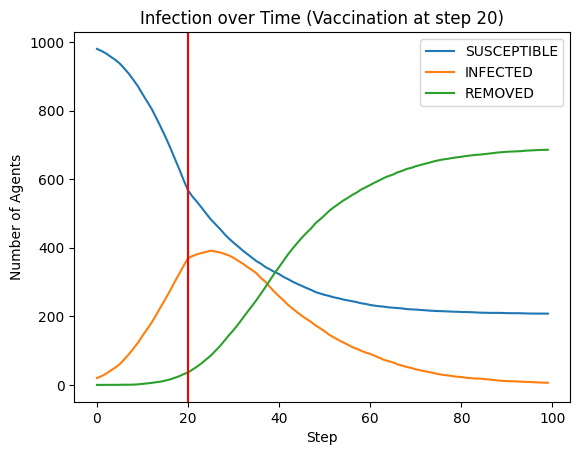

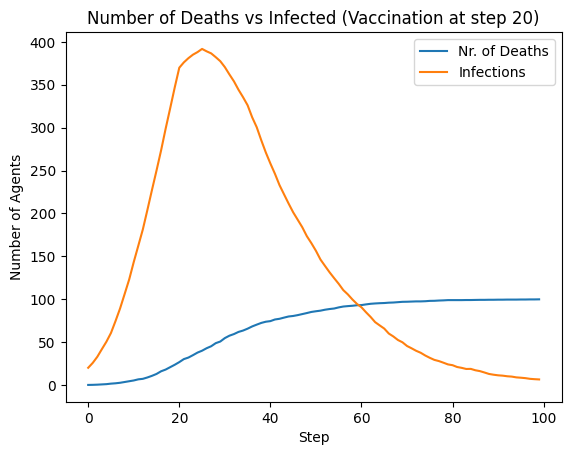

Iteration 0: Vaccination Infection Model ran for 100 steps
Iteration 1: Vaccination Infection Model ran for 100 steps
Iteration 2: Vaccination Infection Model ran for 100 steps
Iteration 3: Vaccination Infection Model ran for 100 steps
Iteration 4: Vaccination Infection Model ran for 100 steps
Iteration 5: Vaccination Infection Model ran for 100 steps
Iteration 6: Vaccination Infection Model ran for 100 steps
Iteration 7: Vaccination Infection Model ran for 100 steps
Iteration 8: Vaccination Infection Model ran for 100 steps
Iteration 9: Vaccination Infection Model ran for 100 steps


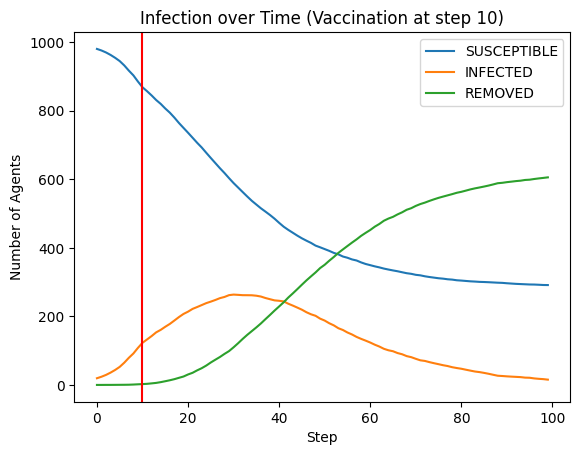

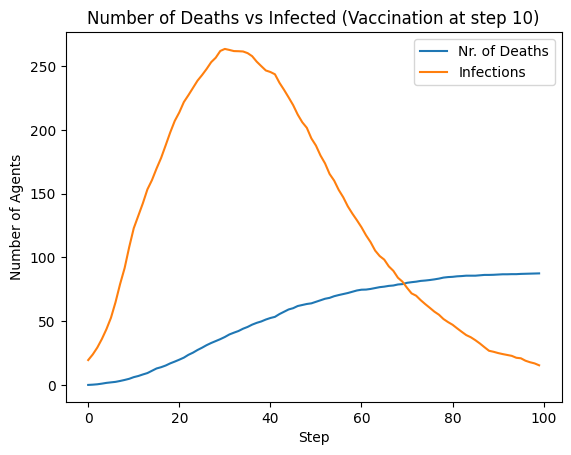

Iteration 0: Vaccination Infection Model ran for 100 steps
Iteration 1: Vaccination Infection Model ran for 100 steps
Iteration 2: Vaccination Infection Model ran for 100 steps
Iteration 3: Vaccination Infection Model ran for 100 steps
Iteration 4: Vaccination Infection Model ran for 100 steps
Iteration 5: Vaccination Infection Model ran for 100 steps
Iteration 6: Vaccination Infection Model ran for 100 steps
Iteration 7: Vaccination Infection Model ran for 100 steps
Iteration 8: Vaccination Infection Model ran for 100 steps
Iteration 9: Vaccination Infection Model ran for 100 steps


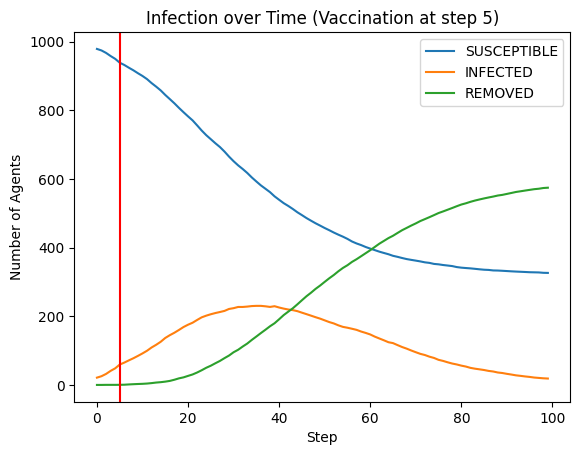

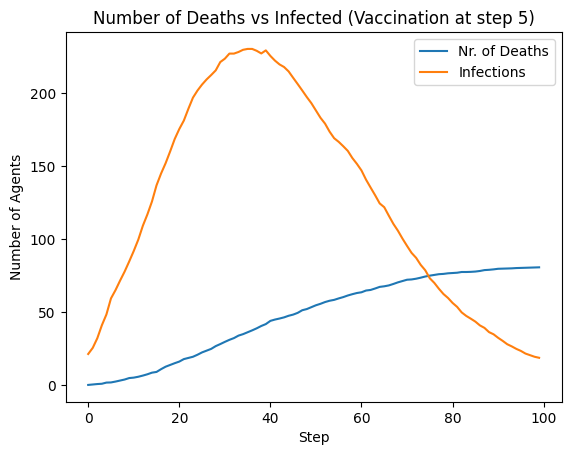

In [19]:
params = {'N': 1000,
          'ptrans': 0.5,
          'vacc_protection': 0.8,
          'vaccination_time': 20,
          'vacc_proportion': 0.7,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 45,
          'height': 45}

pseudo_batch_runner_vaccinated(10, f"(Vaccination at step {params['vaccination_time']})", params)

params['vaccination_time'] = 10
pseudo_batch_runner_vaccinated(10, f"(Vaccination at step {params['vaccination_time']})", params)

params['vaccination_time'] = 5
pseudo_batch_runner_vaccinated(10, f"(Vaccination at step {params['vaccination_time']})", params)



### Compare difference when 50% 75% 100% of the agents get vaccinated at step 10

Iteration 0: Vaccination Infection Model ran for 100 steps
Iteration 1: Vaccination Infection Model ran for 100 steps
Iteration 2: Vaccination Infection Model ran for 100 steps
Iteration 3: Vaccination Infection Model ran for 100 steps
Iteration 4: Vaccination Infection Model ran for 100 steps
Iteration 5: Vaccination Infection Model ran for 100 steps
Iteration 6: Vaccination Infection Model ran for 100 steps
Iteration 7: Vaccination Infection Model ran for 100 steps
Iteration 8: Vaccination Infection Model ran for 100 steps
Iteration 9: Vaccination Infection Model ran for 100 steps


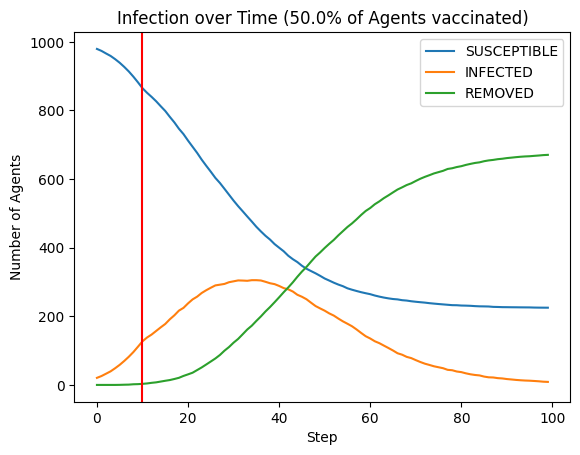

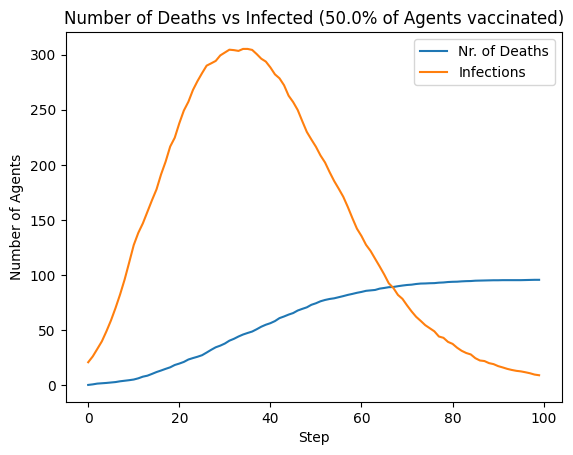

Iteration 0: Vaccination Infection Model ran for 100 steps
Iteration 1: Vaccination Infection Model ran for 100 steps
Iteration 2: Vaccination Infection Model ran for 100 steps
Iteration 3: Vaccination Infection Model ran for 100 steps
Iteration 4: Vaccination Infection Model ran for 100 steps
Iteration 5: Vaccination Infection Model ran for 100 steps
Iteration 6: Vaccination Infection Model ran for 100 steps
Iteration 7: Vaccination Infection Model ran for 100 steps
Iteration 8: Vaccination Infection Model ran for 100 steps
Iteration 9: Vaccination Infection Model ran for 100 steps


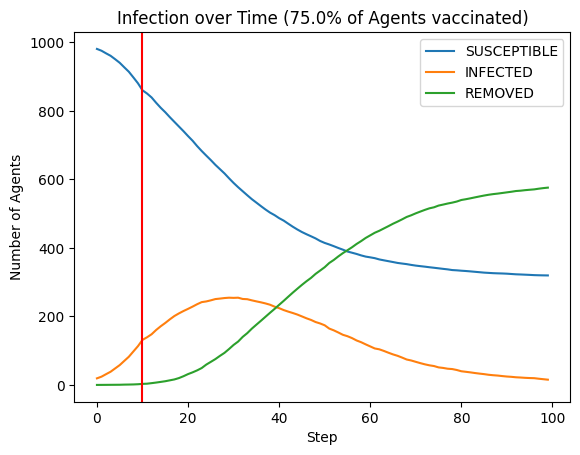

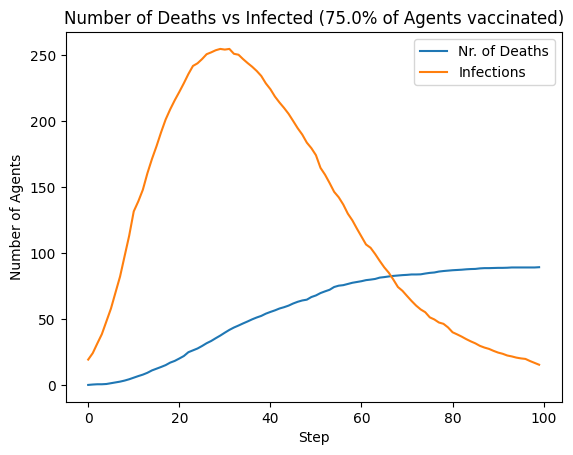

Iteration 0: Vaccination Infection Model ran for 100 steps
Iteration 1: Vaccination Infection Model ran for 100 steps
Iteration 2: Vaccination Infection Model ran for 100 steps
Iteration 3: Vaccination Infection Model ran for 100 steps
Iteration 4: Vaccination Infection Model ran for 100 steps
Iteration 5: Vaccination Infection Model ran for 100 steps
Iteration 6: Vaccination Infection Model ran for 100 steps
Iteration 7: Vaccination Infection Model ran for 100 steps
Iteration 8: Vaccination Infection Model ran for 100 steps
Iteration 9: Vaccination Infection Model ran for 100 steps


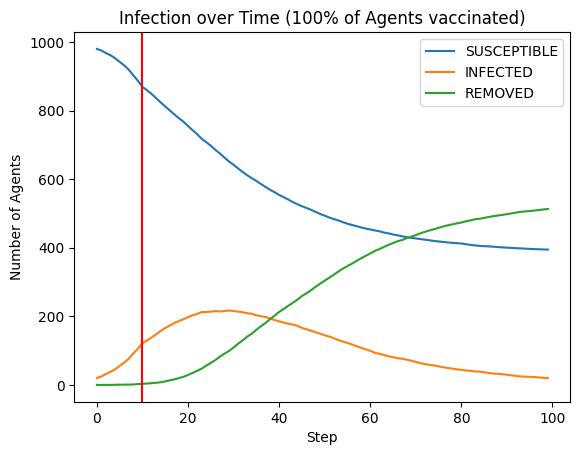

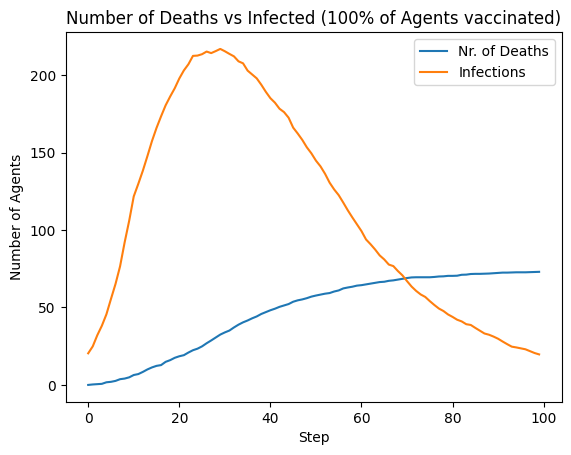

In [21]:
params = {'N': 1000,
          'ptrans': 0.5,
          'vacc_protection': 0.8,
          'vaccination_time': 10,
          'vacc_proportion': 0.5,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 45,
          'height': 45}

pseudo_batch_runner_vaccinated(10, f"({params['vacc_proportion'] * 100}% of Agents vaccinated)", params)

params['vacc_proportion'] = 0.75
pseudo_batch_runner_vaccinated(10, f"({params['vacc_proportion'] * 100}% of Agents vaccinated)", params)

params['vacc_proportion'] = 1
pseudo_batch_runner_vaccinated(10, f"({params['vacc_proportion'] * 100}% of Agents vaccinated)", params)